## Цель проекта

Целью данного исследования является предсказание закрытия стартапов, функционирующих в 1970-2018 года. 

Перед тем, как начать исследование в первой части нам будет необходимо провести предобработку данных. Для начала мы прочитаем все датасеты и проверим названия столбцов и тип данных. Мы проведем поиск пропусков, заполним их, найдем явные и неявные дубликаты и аномалии.

Далее мы проведем исследовательский анализ данных и визуализируем все признаки, которые описывают закрытые и открытые стартапы - количество раундов, общую сумму финансирования страну, город, категорию. Мы также создадим новые признаки - год первого финансирования, время существования стартапа - и проанализируем их. Мы сравним показатели действующих и закрытых стартапов и создадим потрет закрытого стартапа. Исследовательский анализ поможет выяснить, сколько в среднем существуют стартапы, которые, скорее всего, закроются, сколько финансирования они получают, через сколько раундов финансирования проходят и в каких странах их основывают. 

Следующим нашим шагом будет корреляционный анализ признаков в датасете. Мы изучим взаимосвязь между признаками и рассчитаем коэффициенты корреляции. Мы изучим мультиколлинеарность между входными признаками. Мы построим диаграммы рассеивания для всех  признаков и целевого признака статус компании. В конце анализа мы опишем связь между входными и целевым признаками.

Для поиска лучшей модели, которая сможет прогнозировать статус компании, мы будем использовать пайплайн. С помощью него мы закодируем количественные и категориальные признаки, и обучим наши тренировочные данные на нескольких моделях. С помощью RandomizedSearchCV мы переберем все модели и их гиперпараметры, и найдем модель с лучшей F1 метрикой на кросс-валидационной выборке. 

Мы построим график важности  признаков по величине коэффициентов и дерево решений и узнаем, какие признаки больше всего влияют на статус стартапа. 


## 1. Загрузка и чтение данных

In [1]:
!pip install phik -q
!pip install missingno
!pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
import phik
from matplotlib import pyplot as plt
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)

In [3]:
def datetime(data, column):
    data[column] = pd.to_datetime(data[column], format = '%Y-%m-%d')

In [4]:
def pivot(data, index, values, aggfunc):
    return data.pivot_table(index=index, values = values, aggfunc = aggfunc)

In [5]:
def pie(numbers, labels, title):
    subs_pivot = numbers
    fig, ax = plt.subplots()
    ax.pie(subs_pivot, labels = labels, shadow=True, autopct='%1.0f%%')
    plt.title(title);

In [6]:
def two_hist(closed,operating, title):
    plt.hist(closed, bins=10, alpha=0.5, label='Закрытые стартапы', density = True)
    plt.hist(operating, bins=10, alpha=0.5, label='Действующие стартапы', density = True)
    plt.legend(loc='upper right')
    plt.title(title)
    plt.show()
    plt.ticklabel_format(style='plain')

In [7]:
def hist(column, xlabel, ylabel, title):
    plt.hist(column, bins = 5)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ticklabel_format(style='plain')

In [8]:
def hist_dates(column, xlabel, ylabel, title):
    plt.hist(column, bins = 5)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)


In [9]:
def scatter(x, y, hue,title):
    sns.scatterplot(x = startups_train[x], y =startups_train[y], hue = startups_train[hue]).set_title(title);

In [10]:
def status_binary(row):
    status = row['status']
    if status == 'closed':
        return 1
    return 0

In [11]:
def status_cat(row):
    predicts = row['status']
    if predicts == 1:
        return 'closed'
    return 'operating'

In [12]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [13]:
startups_train = pd.read_csv('/Users/macbook/Desktop/start up/kaggle_startups_train_28062024.csv')
startups_test = pd.read_csv('/Users/macbook/Desktop/start up/kaggle_startups_test_28062024.csv')

In [14]:
startups_train.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


In [15]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


Сразу видно, что необходимо изменить тип данных столбцов с датами. Также мы видим большое количество пропусков в столбцах, связанных с географическим расположением стартапа, общей суммой финансирования. Только 5 тысяч стартапов из 52 516 имеют информацию о их закрытии.

In [16]:
startups_test.head(10)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
5,Quickfire Games,Design|Entertainment|Games,160000.0,NaN,NaN,NaN,NaN,2,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,26842000.0,USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018
7,Triosyn,Health Care|Medical|Therapeutics,4000000.0,NaN,NaN,NaN,NaN,1,2003-06-02,2003-06-02,5576
8,Urgent.ly,Software,8710000.0,USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826
9,Map Decisions,Software,13200.0,USA,PA,Allentown,Bethlehem,1,2013-08-09,2013-08-09,2057


In [17]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


Мы видим, что в датасете с тестовыми данными имеет меньше столбцов, чем датасет с тренировочными данными. В нем отсутвуют данные об открытии и закрытии стартапов.

В тестовых данных также необходимо будет заполнить пропуски в столбцах с финансированием и географическим расположением, и изменить тип данных в столбцах с датами. 

## Предобработка данных

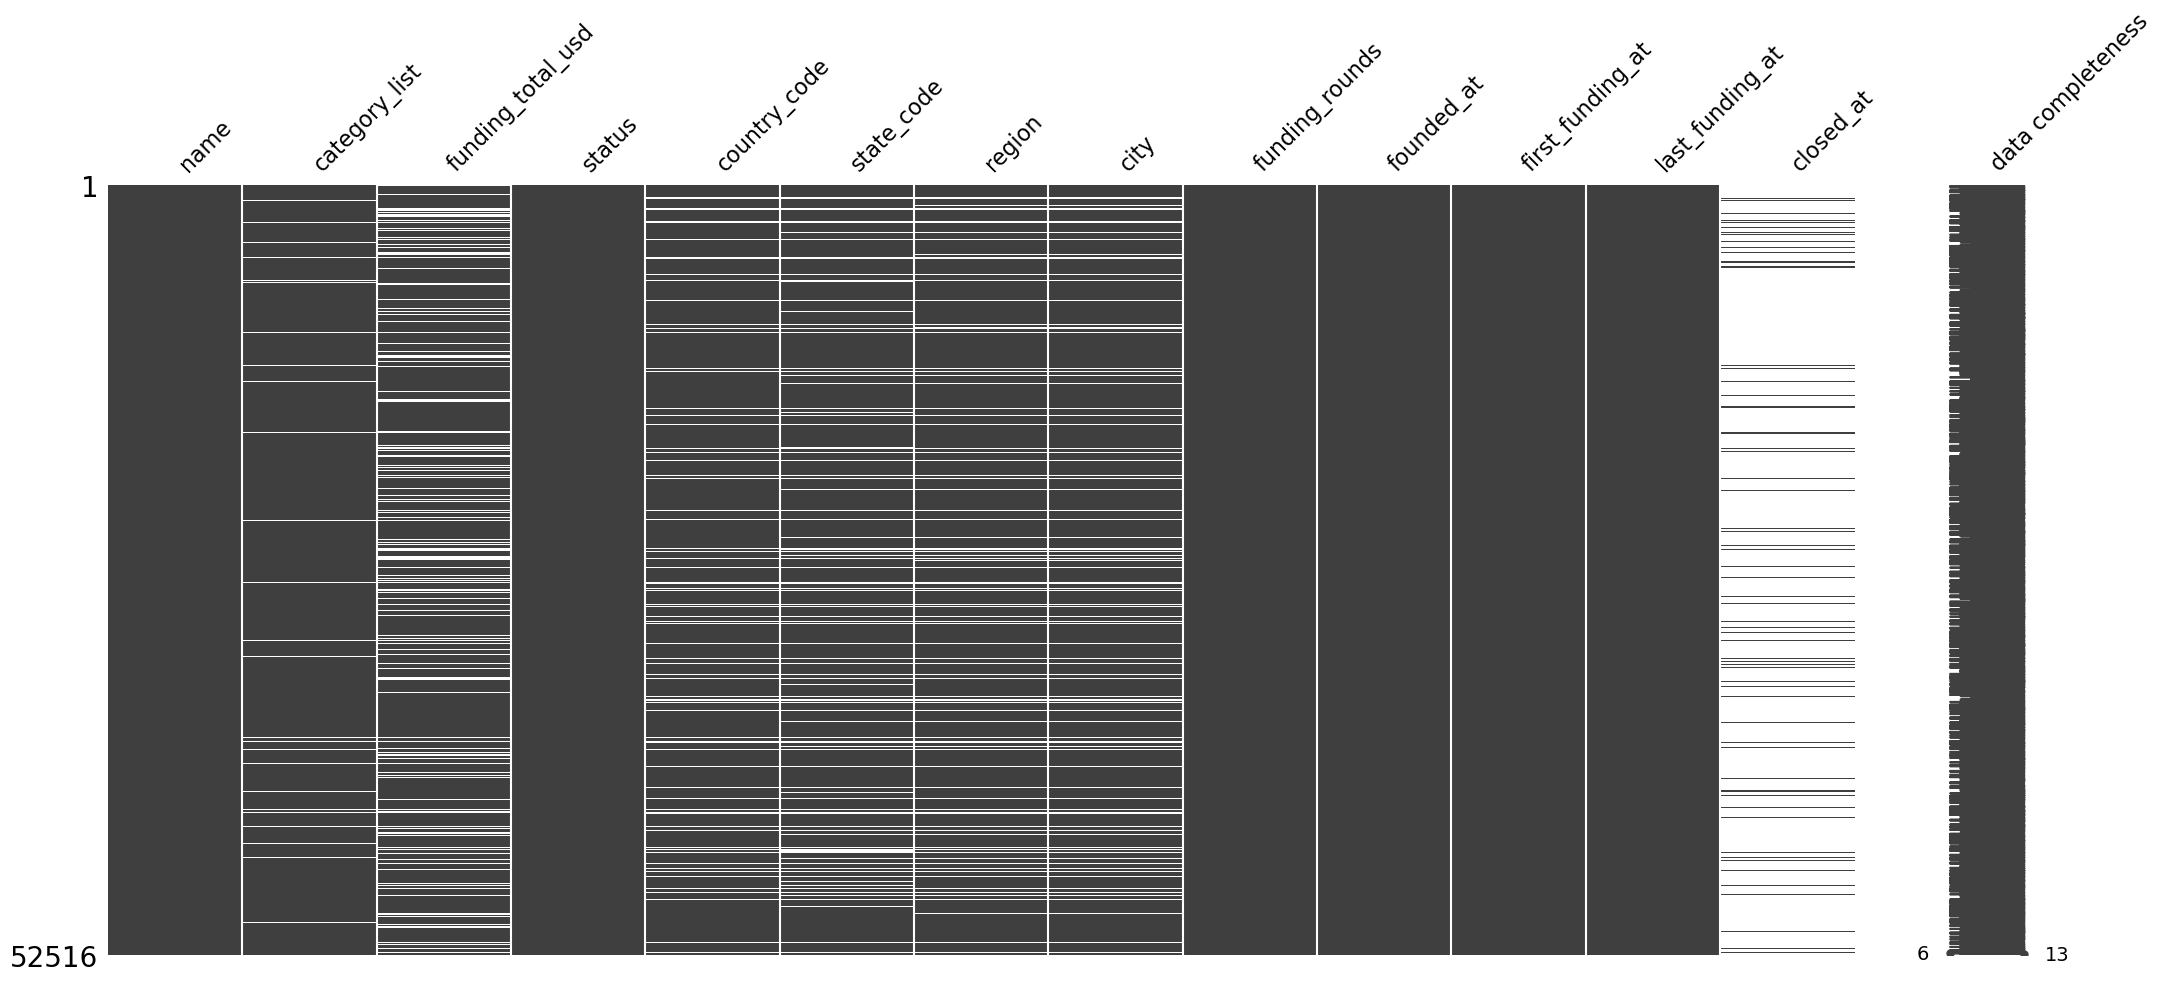

In [18]:
msno.matrix(startups_train, labels=True);

In [19]:
startups_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

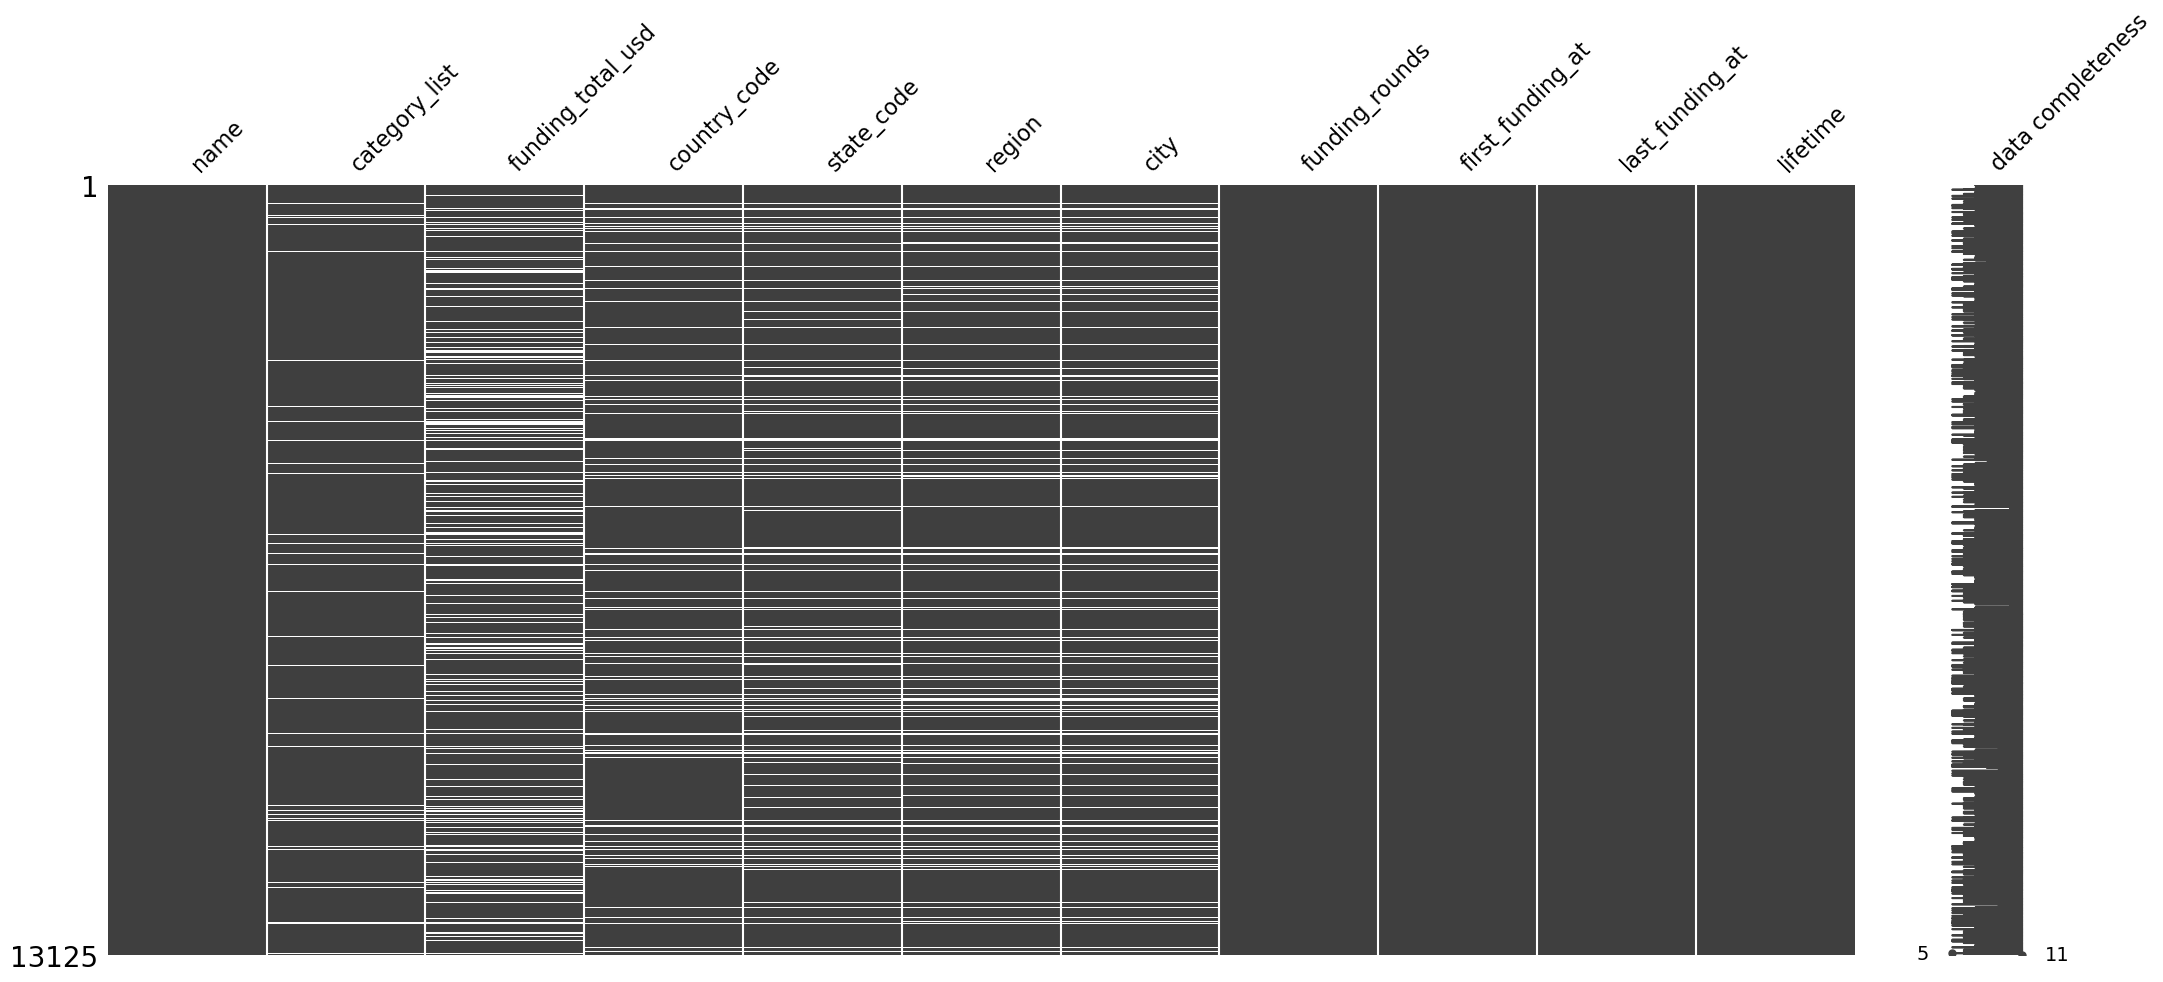

In [20]:
msno.matrix(startups_test, labels=True);

In [21]:
startups_test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

Пропуски в столбцах с списком категорий и географическим положением мы заполним значением 'unknown', столбец с суммой финансировая - медианой. А столбец с датой закрытия заполним датой выгрузки датасета - 2018-01-01.

In [22]:
startups_train['closed_at'].fillna(pd.to_datetime('2018-01-01'), inplace=True)

In [23]:
startups_train['category_list'].fillna('unknown',inplace=True)
startups_test['category_list'].fillna('unknown', inplace = True)

In [24]:
startups_train['funding_total_usd'].fillna(startups_train['funding_total_usd'].median(),inplace=True)
startups_test['funding_total_usd'].fillna(startups_test['funding_total_usd'].median(),inplace=True)


In [25]:
startups_test.isna().sum()

name                    0
category_list           0
funding_total_usd       0
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

In [26]:
startups_train.isna().sum()

name                    1
category_list           0
funding_total_usd       0
status                  0
country_code         5502
state_code           6763
region               6359
city                 6359
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
closed_at               0
dtype: int64

In [27]:
print('Кол-во дубликатов в тренировочной выборке:', startups_train.duplicated().sum())

Кол-во дубликатов в тренировочной выборке: 0


In [28]:
print('Кол-во дубликатов в тестовой выборке:', startups_test.duplicated().sum())

Кол-во дубликатов в тестовой выборке: 0


Полные дубликаты в тренировочной и тестовой выборках отсутствуют. 

In [29]:
startups_train['category_list'].unique().tolist()

['Online Reservations|Restaurants',
 'Manufacturing|Medical|Medical Devices',
 'Biotechnology',
 'Health Care',
 'Manufacturing',
 'Mobile',
 'Analytics|Business Analytics|Social CRM|Social Media Monitoring|Software',
 'Software',
 'Semiconductors',
 'Clean Technology',
 'unknown',
 'Nanotechnology|Technology|Wine And Spirits',
 'Customer Service|Delivery|Retail',
 'Analytics|Cloud Data Services|Computers|Networking|Software',
 'Banking|Finance|Loyalty Programs',
 'Messaging',
 'Consumers',
 'Generation Y-Z|Photo Sharing|Social Media',
 'College Recruiting|Enterprise Software|Recruiting|SaaS|Social Recruiting|Software',
 'Technology',
 'Finance|Financial Services|Payments',
 'Cloud Computing|Enterprise Resource Planning|Manufacturing|Software',
 'DIY|Environmental Innovation',
 'Entertainment|Games',
 'Internet|Pets|Services',
 'Advertising|Sales and Marketing',
 'Fitness|Sports',
 'Consumer Goods|Food Processing|Organic Food',
 'Analytics|Big Data|Business Intelligence|Marketplaces',


Из-за огромного количества категорий данный признак не принесет пользы нашей модели. 



<font color='green'>
<b>Комментарий студента </b>
    
    
Есть ли какой-нибудь способ использовать категории? У меня была мысль создать главные категории по типу - it, медицина, спорт и тд. Но это бы заняло слишком много времени... </font>

In [30]:
startups_train['country_code'].unique()

array(['CHE', 'USA', nan, 'GBR', 'RUS', 'ESP', 'FRA', 'SWE', 'IND', 'KOR',
       'AUS', 'TWN', 'CHN', 'HUN', 'CAN', 'FIN', 'BRA', 'EGY', 'PRT',
       'ISR', 'CHL', 'SVK', 'NLD', 'ARG', 'ARE', 'JPN', 'IRL', 'DEU',
       'LBN', 'EST', 'IDN', 'BEL', 'MEX', 'DNK', 'ITA', 'GRC', 'ROM',
       'TUR', 'SGP', 'SAU', 'MYS', 'NGA', 'QAT', 'VNM', 'BGR', 'GHA',
       'UGA', 'JOR', 'AUT', 'PAK', 'NZL', 'HKG', 'ZAF', 'LVA', 'NOR',
       'HRV', 'VEN', 'PER', 'LUX', 'SVN', 'POL', 'PHL', 'NIC', 'CZE',
       'ISL', 'PAN', 'URY', 'BGD', 'MCO', 'GTM', 'THA', 'TTO', 'UKR',
       'KEN', 'CRI', 'DZA', 'LTU', 'CYM', 'MUS', 'BLR', 'SLV', 'COL',
       'MLT', 'PSE', 'BLZ', 'CYP', 'MMR', 'MKD', 'KHM', 'GIB', 'SRB',
       'DOM', 'BWA', 'BLM', 'PRY', 'BMU', 'TAN', 'LIE', 'GRD', 'UZB',
       'GEO', 'SEN', 'ALB', 'ECU', 'MOZ', 'LKA', 'LAO', 'TUN', 'HND',
       'ZWE', 'BAH', 'MDA', 'MAF', 'BHR', 'AZE', 'MAR', 'KWT', 'IRN',
       'GGY', 'KNA', 'PRI', 'OMN', 'KAZ', 'JAM', 'NPL', 'ARM', 'TGO',
       'RWA', '

In [31]:
def country(row):
    country = row['country_code']
    if country in ['FRA', 'NLD', 'DEU', 'BEL', 'AUT', 'LUX', 'CHE', 'ISL', 'MCO', 'LIE']:
        return 'Western Europe'
    if country in ['RUS', 'UKR' ,'ROM', 'SVK' ',HUN', 'EST' , 'BGR'  ,'LVA' ,'HRV' ,'SVN' ,
                   'POL' ,'CZE' ,'LTU' ,'BLR', 'MKD' ,'SRB' ,'ALB' ,'MDA','MNE']:
        return 'Eastern Europe'
    if country in ['SWE', 'FIN','DNK' ,'NOR' ]:
        return 'Northern Europe'
    if country in ['ESP' ,'ITA', 'GRC', 'PRT' ,'TUR' , 'MLT', 'CYP']:
        return 'Southern Europe'
    if country in ['IRE','GBR','GGY','JEY']:
        return 'British Isles'
    if country in ['USA','  CAN', 'MEX']:
        return 'North America'
    if country in ['BRA','CHL' ,'ARG' ,'VEN' ,'PER' , 'URY', 'COL' ,'PRY', 'ECU']:
        return 'South America'
    if country in ['KOR', 'TWN', 'CHN' ,'JPN', 'VNM', 'HKG', 'THA' ,'KHM' ,'UZB', 'KAZ', 'NPL', 'BRN']:
        return 'Asia'
    if country in ['IND' ,'IDN', 'MYS', 'PAK' ,'SGP','PHL' ,'BGD', 'MMR', 'LKA' ,'LAO']:
        return 'South Asia'
    if country in ['AUS', 'NZL']:
        return 'Australia'
    if country in ['ISR', 'ARE', 'LBN', 'SAU', 'QAT' ,'JOR' ,'PSE', 'KWT' ,
                   'IRN', 'AZE' ,'OMN', 'ARM', 'GEO' ,'BHR']:
        return 'Middle East'
    if country in ['NIC','PAN', 'DOM' ,'PRI' ,'JAM' ,'GTM', 'TTO', 'SLV',
                   'CRI' ,'CYM' ,'BLZ', 'BLM' ,'BMU', 'GRD' ,'HND' ,'BAH', 'MAF', 'KNA']:
        return 'Central America'
    if country in ['EGY', 'NGA' ,'GHA', 'UGA', 'ZAF', 'KEN' ,'DZA', 'TAN' ,'SEN', 'MOZ',
                   'TUN' ,'ZWE', 'MAR' ,'RWA' ,'SOM', 'CMR' ,'ZMB', 'MUS' ,'GIB','BWA' ,'TGO' ,'SYC']:
        return 'Africa'
    return 'unknown'

In [32]:
startups_train['geo_region'] = startups_train.apply(country, axis = 1)

Было принято решение объединить страны по географическому расположению, так как большое количество категориальных значений навредило бы нашей модели.

In [33]:
datetime(startups_train, 'founded_at')
datetime(startups_train, 'first_funding_at')
datetime(startups_train, 'last_funding_at')
datetime(startups_train, 'closed_at')
datetime(startups_test, 'first_funding_at')
datetime(startups_test, 'last_funding_at')

In [34]:
startups_train.dtypes

name                         object
category_list                object
funding_total_usd           float64
status                       object
country_code                 object
state_code                   object
region                       object
city                         object
funding_rounds                int64
founded_at           datetime64[ns]
first_funding_at     datetime64[ns]
last_funding_at      datetime64[ns]
closed_at            datetime64[ns]
geo_region                   object
dtype: object

In [35]:
startups_test.dtypes

name                         object
category_list                object
funding_total_usd           float64
country_code                 object
state_code                   object
region                       object
city                         object
funding_rounds                int64
first_funding_at     datetime64[ns]
last_funding_at      datetime64[ns]
lifetime                      int64
dtype: object

Были изменен тип данных в столбцах с датами. 

In [36]:
startups_train['first_last_funding_diff'] = (startups_train['last_funding_at'] - startups_train['first_funding_at']).dt.days

In [37]:
startups_test['first_last_funding_diff'] = (startups_test['last_funding_at'] - startups_test['first_funding_at']).dt.days

Мы создали новый признак - разница между первым и последним финансированиям (в днях). Это может помочь модели лучше искать связи между стартапом и статусом его работы. 

In [38]:
startups_train.head(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,geo_region,first_last_funding_diff
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Western Europe,1310
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,North America,1393
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,North America,681
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,unknown,1051
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,North America,0


## Исследовательский анализ 

In [39]:
def hist_and_boxx(column):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x=column, ax=ax_box)
    sns.histplot(x=column, bins=5, kde=True, ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.ticklabel_format(style='plain')

In [40]:
pivot(startups_train, 'status', 'name','count')

,name
status,
closed,4916
operating,47599


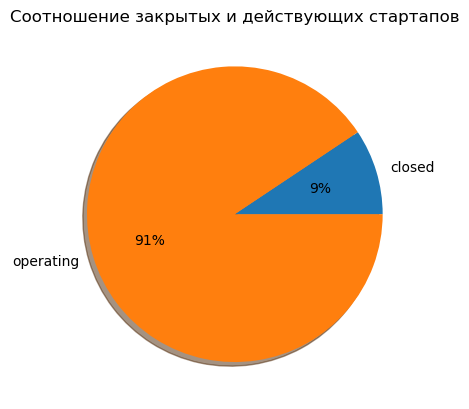

In [41]:
pie([4916, 47599], ['closed', 'operating'], 'Соотношение закрытых и действующих стартапов')

В нашем датасете только 9% стартапов закрылись до даты выгрузки (01.01.2018)

In [42]:
pivot(startups_train[startups_train['status'] == 'closed'],
      'category_list', 'status', 'count').sort_values(by ='status', ascending = False).head(10)

,status
category_list,
unknown,729
Software,268
Biotechnology,186
Curated Web,175
Clean Technology,84
Mobile,83
E-Commerce,76
Games,76
Advertising,65


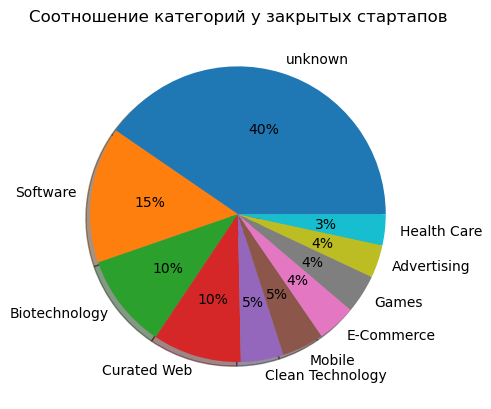

In [43]:
pie([729,268,186,175,84,83,76,76,65,61], ['unknown', 'Software', 'Biotechnology',
                                          'Curated Web','Clean Technology','Mobile','E-Commerce',
                                          'Games','Advertising','Health Care'],
   'Соотношение категорий у закрытых стартапов')

У почти половины закрытых стартапов нет информации о категории их деятельности. Большую часть известных категорий занимает програмное обеспечение, биотехнологии и curated web.

In [44]:
pivot(startups_train[startups_train['status'] == 'operating'],
      'category_list', 'status', 'count').sort_values(by ='status', ascending = False).head(10)

,status
category_list,
Software,2939
Biotechnology,2719
unknown,1736
E-Commerce,988
Mobile,837
Clean Technology,808
Health Care,683
Curated Web,678
Hardware + Software,675


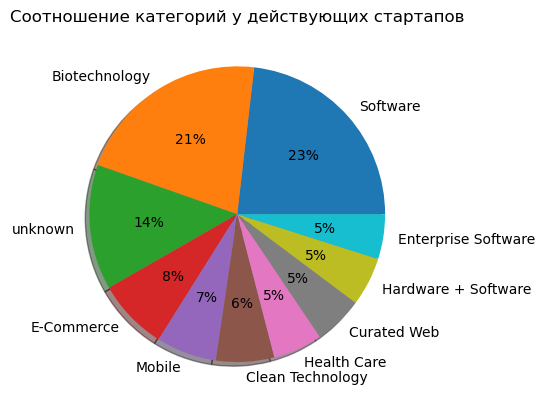

In [45]:
pie([2939,2719,1736,988,837,808,683,678,675,622], ['Software', 'Biotechnology', 'unknown',
                                          'E-Commerce','Mobile','Clean Technology','Health Care',
                                          'Curated Web','Hardware + Software','Enterprise Software'],
   'Соотношение категорий у действующих стартапов')

Единственное, что можно сказать про соотношение категорий у дествующих стартапов в сравнении с предыдущим графиком - стартапы с неизвестными категориями занимают только третье место по численности. В основном соотношения других категорий похожи. Поэтому, можно сказать, что определенные категории не сильно влияют на статус стартапа. 

In [46]:
pivot(startups_train[startups_train['status'] == 'closed'],
      'geo_region', 'status', 'count').sort_values(by ='status', ascending = False).head(10)

,status
geo_region,
North America,2295
unknown,1442
British Isles,234
Western Europe,211
Eastern Europe,164
Asia,104
South Asia,97
Northern Europe,83
South America,79


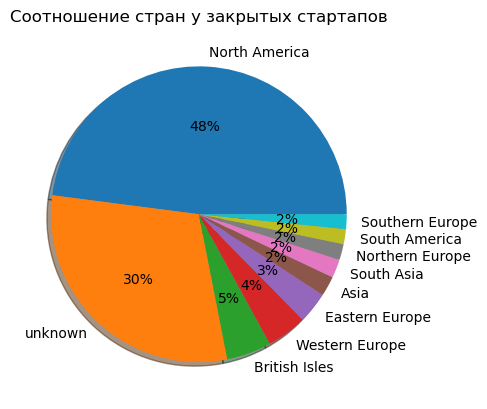

In [47]:
pie([2295,1442,234,211,164,104,97,83,79,77], ['North America', 'unknown', 'British Isles',
                                          'Western Europe','Eastern Europe','Asia','South Asia',
                                          'Northern Europe','South America','Southern Europe'],
   'Соотношение стран у закрытых стартапов')

Большинство закрытых стартапов были основаны в Северной Америке. В датасете с закрытыми стартапами нет информации о стране порядка 30% стартапов. Также на графике мы видим, что Британские острова, восточная и западная Европа занимают 5, 4, 3 процента соответственно. 

In [48]:
pivot(startups_train[startups_train['status'] == 'operating'],
      'geo_region', 'status', 'count').sort_values(by ='status', ascending = False).head(10)

,status
geo_region,
North America,27522
unknown,6020
British Isles,2693
Western Europe,2484
Asia,2047
South Asia,1781
Southern Europe,1133
Northern Europe,871
Middle East,843


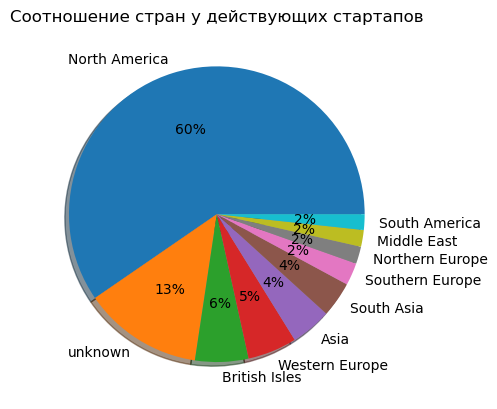

In [49]:
pie([27522,6020,2693,2484,2047,1781,1133,871,843,791], ['North America', 'unknown', 'British Isles',
                                          'Western Europe','Asia','South Asia','Southern Europe',
                                          'Northern Europe','Middle East','South America'],
   'Соотношение стран у действующих стартапов')

Мы видим, что действующих стартапов из Северной Америки большинство - около 60%. Этот процент больше, чем на графике для закрытых стартапов. Также, мы видим на 17% меньше стартапов с неизвестным географическим положением. Также стоит заметить, что на графике отсутствуют стартапы из Восточной Европы. 

In [50]:
pivot(startups_train[startups_train['status'] == 'closed'],
      'city', 'status', 'count').sort_values(by ='status', ascending = False).head(10)

,status
city,
San Francisco,259
New York,199
London,108
Moscow,83
Los Angeles,72
Palo Alto,65
Austin,59
Seattle,52
Toronto,43


In [51]:
pivot(startups_train[startups_train['status'] == 'operating'],
      'city', 'status', 'count').sort_values(by ='status', ascending = False).head(10)

,status
city,
San Francisco,2565
New York,2287
London,1406
Austin,550
Palo Alto,542
Seattle,540
Los Angeles,532
Chicago,508
Cambridge,507


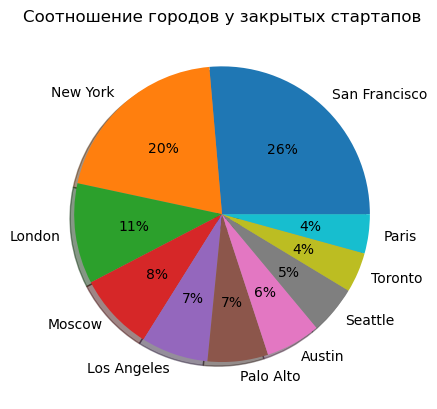

In [52]:
pie([259,199,108,83,72,65,59,52,43,42], ['San Francisco', 'New York', 'London',
                                          'Moscow','Los Angeles','Palo Alto','Austin',
                                          'Seattle','Toronto','Paris'],
   'Соотношение городов у закрытых стартапов')

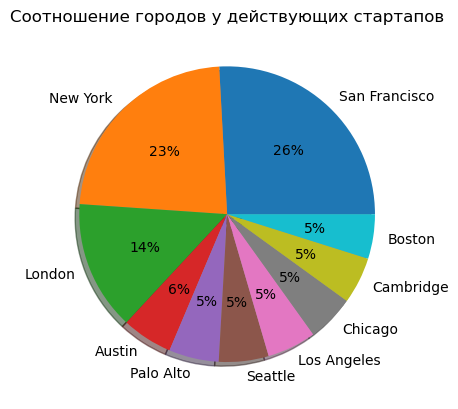

In [53]:
pie([2565,2287,1406,550,542,540,532,508,507,483], ['San Francisco', 'New York', 'London',
                                          'Austin','Palo Alto','Seattle','Los Angeles',
                                          'Chicago','Cambridge','Boston'],
   'Соотношение городов у действующих стартапов')

Сравнивая графика топ-10 городов, где были основаны действующие и закрытые стартапы. Первое, что можно заметить, что Москва входит в топ 4 городов, в которых закрылись стартапы, и вообще отствует в топ-10 действующих стартапов. То же самое можно сказать про Париж и Торонто.
Как мы уже видели на графике географического положения, большинство стартапов основываются в США и Великобритании.

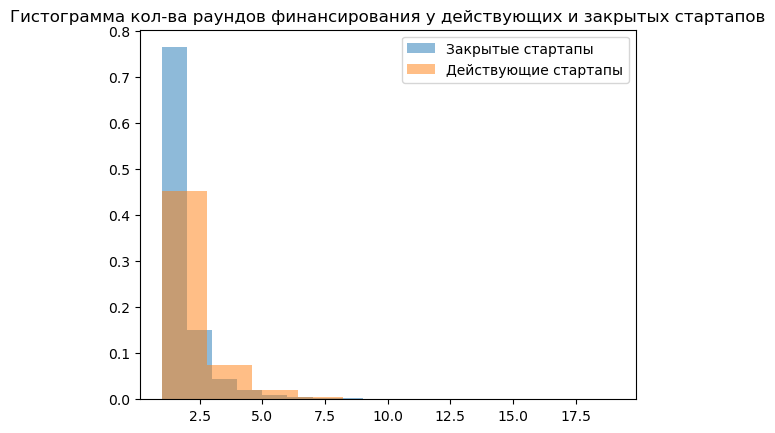

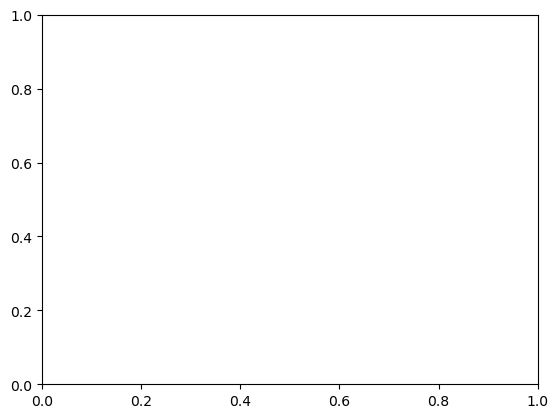

In [54]:
two_hist(startups_train['funding_rounds'][startups_train['status'] == 'closed'],
        startups_train['funding_rounds'][startups_train['status'] == 'operating'],
         'Гистограмма кол-ва раундов финансирования у действующих и закрытых стартапов')


<font color='green'>
<b>Комментарий студента</b>
    
Я не смогла разобраться, почему появляется второй пустой график.. Поэтому не очень красиво </font>



Данные гистограммы для закрытых и действующих стартапов показывают, что закрытые стартапы реже проходят первый этап финансирования. Этот признак должен хорошо себя показать в поиске модели для предсказания закрытия стартапа. 

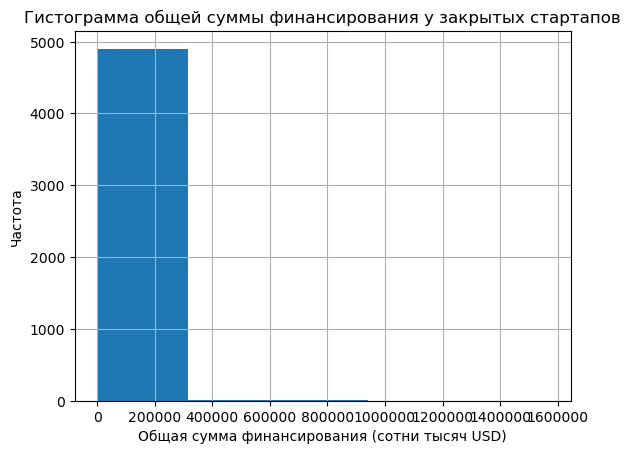

In [55]:
hist(startups_train['funding_total_usd'][startups_train['status'] == 'closed'] / 1000, 'Общая сумма финансирования (сотни тысяч USD)', 'Частота',
     'Гистограмма общей суммы финансирования у закрытых стартапов')

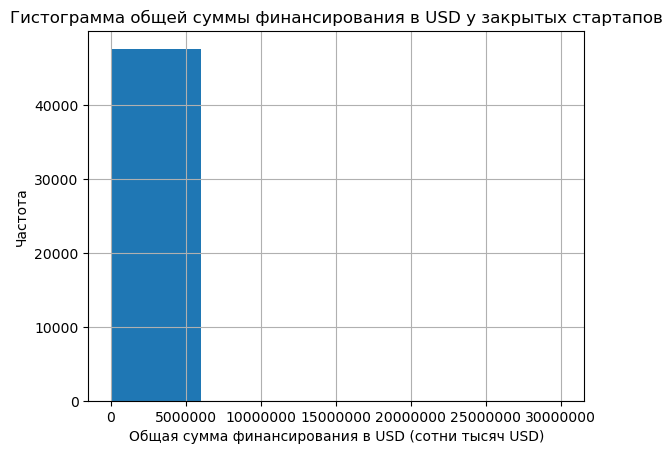

In [56]:
hist(startups_train['funding_total_usd'][startups_train['status'] == 'operating'] / 1000, 'Общая сумма финансирования в USD (сотни тысяч USD)', 'Частота',
     'Гистограмма общей суммы финансирования в USD у закрытых стартапов')

Гистограммы показывают, что закрытые стартапы практически не получили больше двухсот миллионов долларов финансирования. Действующие стартапы в основном получают до 6 миллиардов долларов, что в тысячи раз превышает показатели закрытых стартапов.

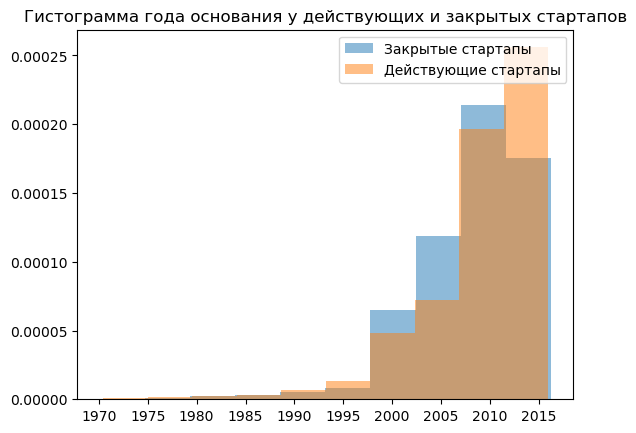

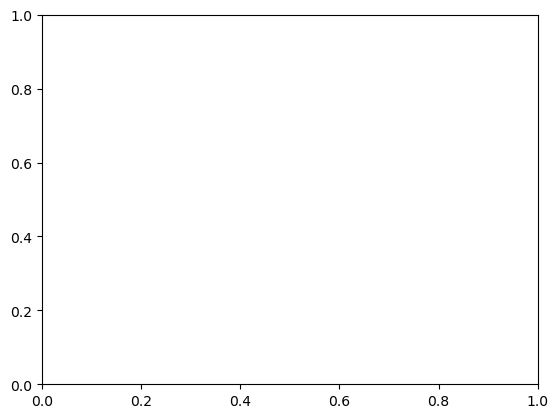

In [57]:
two_hist(startups_train['founded_at'][startups_train['status'] == 'closed'],
        startups_train['founded_at'][startups_train['status'] == 'operating'],
         'Гистограмма года основания у действующих и закрытых стартапов')

Гистограммы для года основания закрытых и действующих стартапов не имеют значимых различий. 

In [58]:
startups_train['lifetime'] = (startups_train['closed_at']-startups_train['founded_at']).dt.days

Создадим новый признак в тренирочной выборке - время существования стартапа в днях.

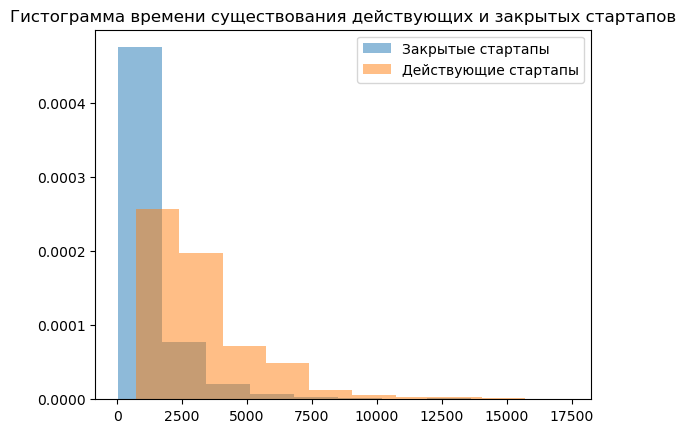

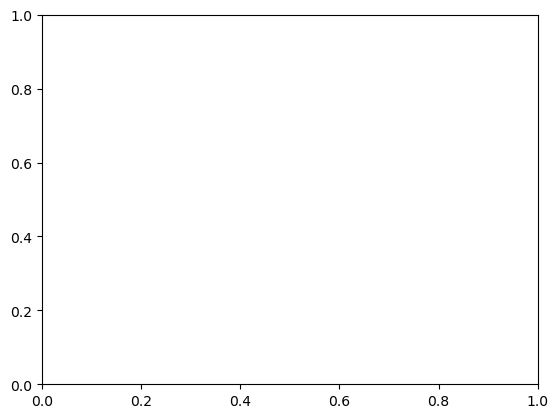

In [59]:
two_hist(startups_train['lifetime'][startups_train['status'] == 'closed'],
        startups_train['lifetime'][startups_train['status'] == 'operating'],
         'Гистограмма времени существования действующих и закрытых стартапов')

На графика четко видно, что закрытые стартапы практически не существуют больше 3000 дней (8 лет).

In [60]:
startups_train['first_funding_year'] = startups_train['first_funding_at'].dt.year
startups_test['first_funding_year'] = startups_test['first_funding_at'].dt.year

Добавим новый признак - год первого раунда финансирования.

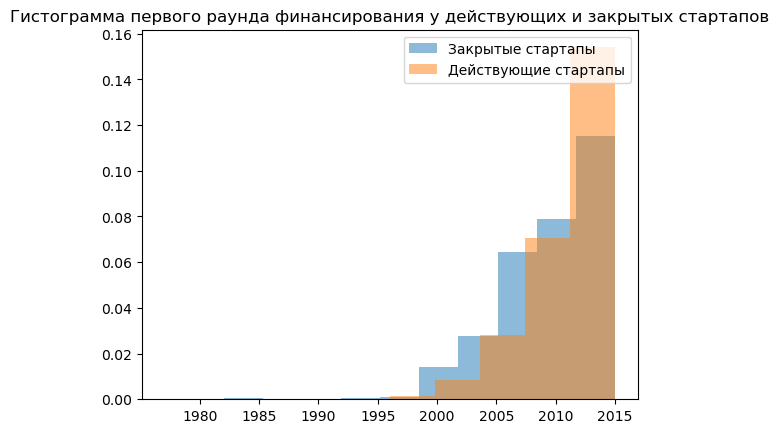

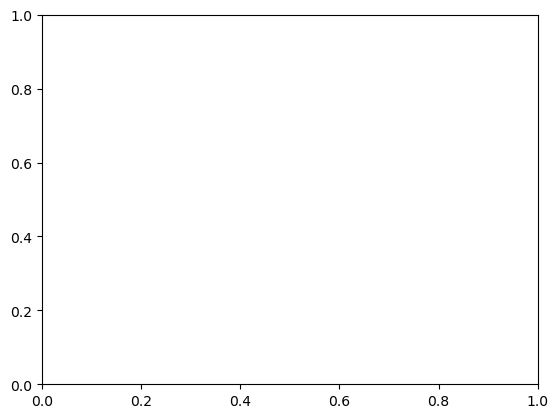

In [61]:
two_hist(startups_train['first_funding_year'][startups_train['status'] == 'closed'],
        startups_train['first_funding_year'][startups_train['status'] == 'operating'],
         'Гистограмма первого раунда финансирования у действующих и закрытых стартапов')

Мы видим, что в 2005-2007 большинство компаний, которые были впервые профинансированы, в итоге закрылись. Также есть скачок закрытых компаний, которые получили финансирование в 2009-2011 годах. Мы будем использовать данный признак для поиска модели.

Мы готовы создать портрет закрытого стартапа. Они относятся к категории програмного обеспечения, биотехнологии либо их категория отсутствует. Закрытый стартап был основан в Северной Америке, либо страна основания неизвестна. Также, стартапы из Восточной Европы, особенно из Москвы, более склонны к закрытию. Закрытые стартапы из Парижа и Торонто также имеют больше шансов закрыться. Закрытые стартапы реже проходя первый раунд финансирования, не получают больше 200 миллионов долларов финансирования и не существуют больше 8 лет. Такие стартапы также впервые финансировались в 2005-2007 и 2009-2011 годах. 

## Корреляционный анализ

In [62]:
startups_train = startups_train.set_index('name')
startups_test = startups_test.set_index('name')

Для удобства корреляционного анализа нашими индексами будет столбец с названиями компаний.


Также из корреляционного анализа будут удалены столбцы с датами.

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'first_last_funding_diff', 'lifetime', 'first_funding_year']


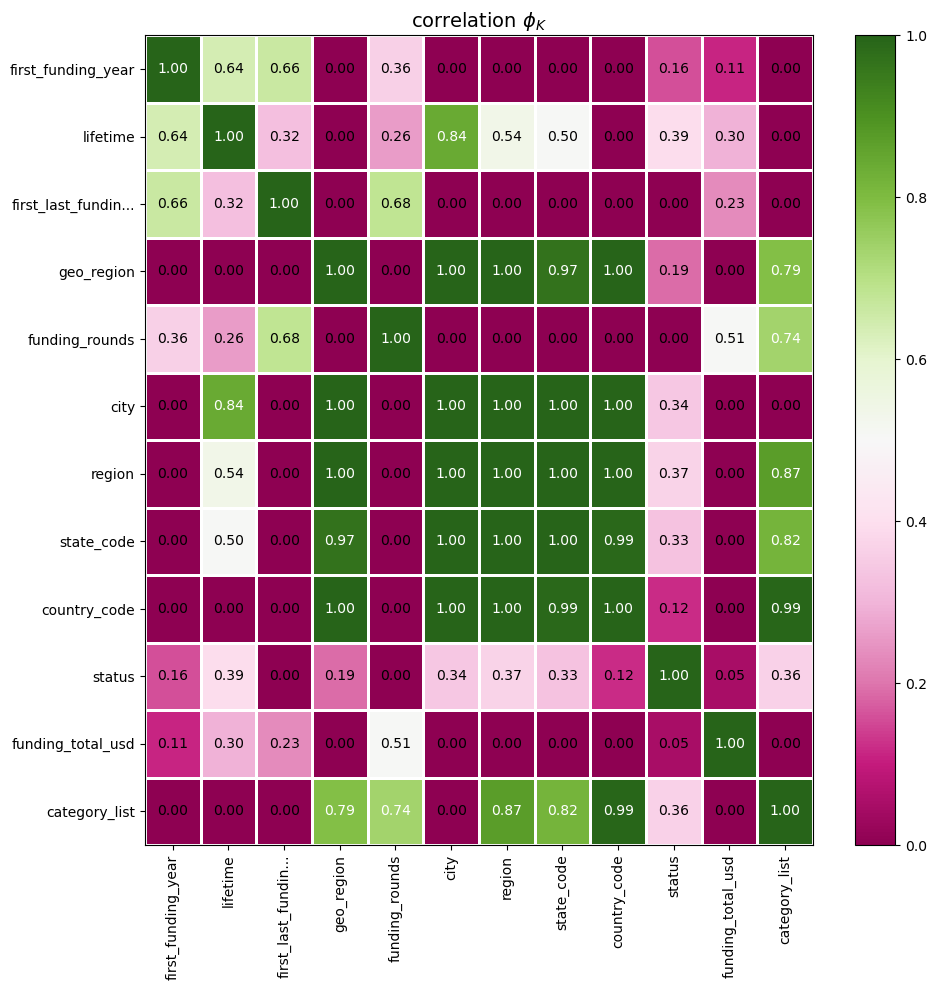

In [63]:
phik_overview = startups_train.drop([
                                      'founded_at','first_funding_at','last_funding_at', 'closed_at',
                                      ], axis = 1).sample(1000).phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='PiYG', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(10,10))
plt.tight_layout()

Наш целевой признак - статус стартапа - сильнее всего коррелирует с временем существования старапа - 0.59. Также статус положительно зависим от таких признаков как список категорий, страна, код штата и год первого финансирования. Мы не видим никакой связи между статусом и количеством раундов, c городом и регионом стартапа.

Мы видим, что все географические признаки имеют практически стопроцентую корреляцию, поэтому, для модели мы отберем только один признак - страну стартапа.

Мы наблюдаем мультиколлениарность у общего финансирования с гордом и регионом, а также высокую корреляцию со списком категорий. Также список категорий мультиколлениарен по отношению к географическим признакам и количеству раундов финансирования. 

Время существования стартапа коррелирует с большинством признаков.

В нашем случае мультиколлениарность не пугает нас - так как в списке используемых моделей будут модели деревьев решений, kNN и логистическая регрессия с регуляризацией.

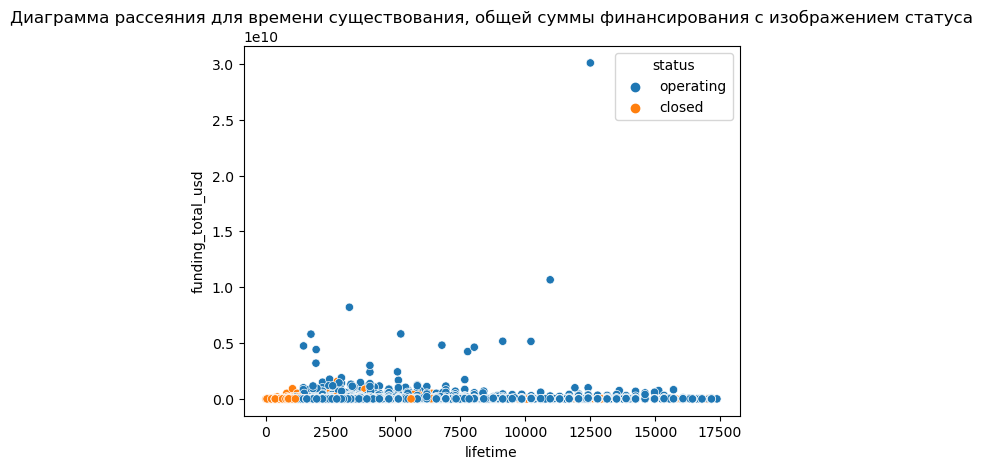

In [64]:
scatter('lifetime', 'funding_total_usd','status',
        'Диаграмма рассеяния для времени существования, общей суммы финансирования с изображением статуса')

Диаграмма рассеяния показывает, что почти все закрытые стартапы существовали меньше 1000 дней. 

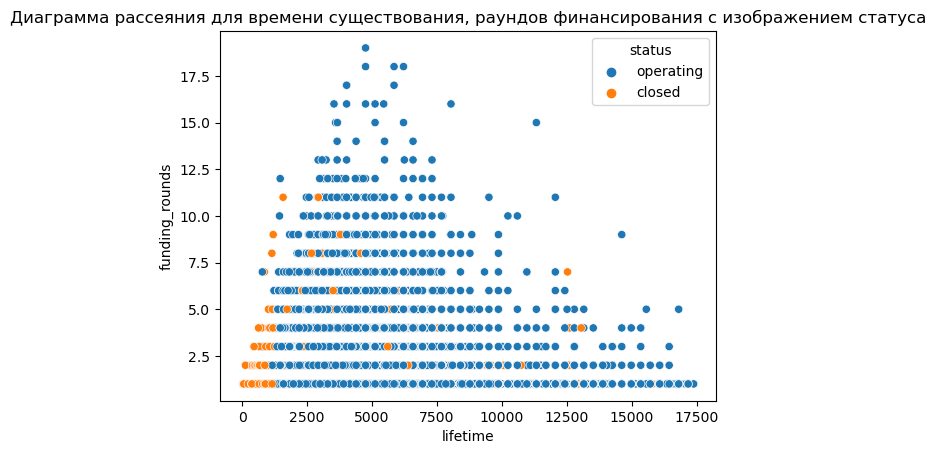

In [65]:
scatter('lifetime', 'funding_rounds','status',
        'Диаграмма рассеяния для времени существования, раундов финансирования с изображением статуса')

Закрытые стартапы очень редко доходят до пятого раунда финансирования.

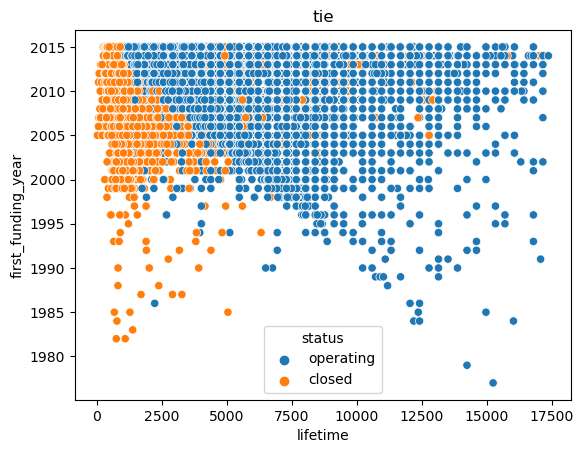

In [66]:
scatter('lifetime', 'first_funding_year','status', 'tie')

Диаграмма показывает, что большинство закрытых стартапов участвовали в раунде финансирования в 2005-2007 годах. 

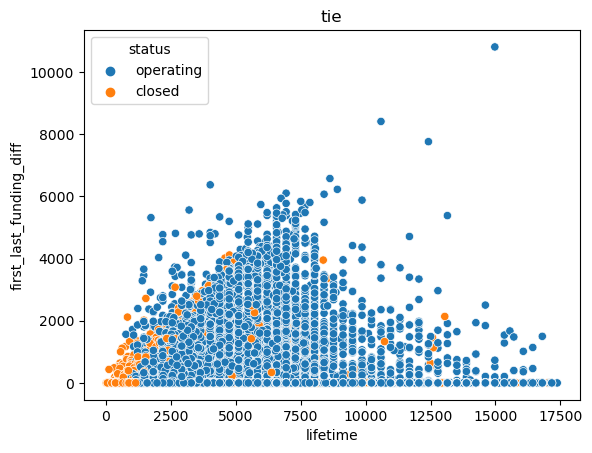

In [67]:
scatter('lifetime', 'first_last_funding_diff','status', 'tie')

У закрытых стартапов разница между первым и вторым финансированием меньше, чем у действующих. 

Корреляционный анализ показал, что наш целевой признак больше всего коррелирует со временем существования стартапа, списком категорий, с кодом штата и страной и годом первого финансирования. Но не коррелирует с количеством раундов, городом и регионом.

Корреляция фика также показала, что между многими входными признаками существует мультиколлинеарность, но так как мы преимущественно будем использовать модели с деревьями решений и регуляризацию в логистической регрессии, мы можем не пытаться это изменить.

Диаграммы рассеяния показали нам еще раз, что большинство закрытых стартапов существовали меньше 1000 дней, практически не доходят до пятого раунда финансирования и участвовали в первом раунде финансирования в 2005-2007 годах.

## Пайплайн

In [68]:
#изменим значение целевого признака на 0 и 1, где 1 - закрытый стартап
startups_train['status'] = startups_train.apply(status_binary, axis = 1)

In [69]:
startups_train.head(5)

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,geo_region,first_last_funding_diff,lifetime,first_funding_year
name,,,,,,,,,,,,,,,,
Lunchgate,Online Reservations|Restaurants,828626.0,0,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,Western Europe,1310,2998,2011
EarLens,Manufacturing|Medical|Medical Devices,42935019.0,0,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,North America,1393,4748,2010
Reviva Pharmaceuticals,Biotechnology,35456381.0,0,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,North America,681,4383,2012
Sancilio and Company,Health Care,22250000.0,0,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,unknown,1051,5114,2011
WireTough Cylinders,Manufacturing,2000000.0,0,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,North America,0,2791,2012


In [70]:
startups_train = startups_train.drop(['region','category_list',
                                      'founded_at','first_funding_at','last_funding_at', 'closed_at',
                                      'city','state_code', 'country_code'], axis = 1)

Было принято решение избавиться от всех признаков с датами, так как каждое значением там уникально и эти признаки никак не помогут нам найти эффективную модель. Мы также не будем использовать признак со списком категорий из-за большого количества значений в нем. Из географических признаков мы оставим только географический регион из-за того, что корреляция межу страной, городом, кодом штатам и регионом практически равна единице. Также, благодаря нашей функции мы уменьшили количество значений для географического признака.

In [71]:
ohe_columns = ['geo_region','first_funding_year']
num_columns = ['funding_total_usd','funding_rounds','first_last_funding_diff', 'lifetime']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(startups_train.drop(columns = 'status', axis = 1),
                                                    startups_train['status'],
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = startups_train['status'])

In [73]:
ohe_pipe = Pipeline(
    [
        (
            'simpleimputer_ohe',
        SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (    
            'ohe',
        OneHotEncoder(drop='first', sparse_output = False, handle_unknown = 'ignore')
        )
    ])

In [74]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
    ('num', [MinMaxScaler(),StandardScaler()], num_columns)],
    remainder = 'passthrough')

In [75]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
    ]
)

In [76]:
parameters_distributions_class = [
    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_leaf': range(2,12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state = RANDOM_STATE, solver='saga', penalty='l1')],
        'models__C': range(1,9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state = RANDOM_STATE, probability = True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [RandomForestClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_leaf': range(2,9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
    
]

In [77]:
#используем randomized_search из-за быстрого результата
randomized_search = RandomizedSearchCV(
    pipe_final, parameters_distributions_class, cv=5, scoring = 'f1',
    random_state = RANDOM_STATE, n_jobs = 1)

In [78]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleimputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['geo_region',
                                                                                'first_funding_year']),
                                                                              ('num',
                                                                               [MinMaxScaler(),
                                                                                S...
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(1, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [RandomForestClassifier(random_state=42)],
                                         'models__max_depth': range(2, 20),
                                         'models__min_samples_leaf': range(2, 9),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='f1')

In [79]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['geo_region',
                                                   'first_funding_year']),
                                                 ('num', MinMaxScaler(),
                           

Наша лучшая модель - DecisionTreeClassifier с max_depth=18 18 и min_samples_leaf=6. В качестве кодировщика количественных признаков модель использует MinMaxScaler().

In [80]:
print ('Метрика F1 лучшей модели на кросс валидационной выборке:', randomized_search.best_score_)

Метрика F1 лучшей модели на кросс валидационной выборке: 0.8463321238625078


In [81]:
res = (
    pd.DataFrame({
        "mean_test_score": randomized_search.cv_results_["mean_test_score"],
        "mean_fit_time": randomized_search.cv_results_["mean_fit_time"]})
      .join(pd.json_normalize(randomized_search.cv_results_["params"]).add_prefix("param_"))
).sort_values(by = 'mean_test_score', ascending = False)

In [82]:
res

,mean_test_score,mean_fit_time,param_preprocessor__num,param_models__min_samples_leaf,param_models__max_depth,param_models
8,0.846332,0.125080,MinMaxScaler(),6,18,DecisionTreeClassifier(random_state=42)
3,0.846154,0.126950,passthrough,7,18,DecisionTreeClassifier(random_state=42)
9,0.838363,0.114643,MinMaxScaler(),11,16,DecisionTreeClassifier(random_state=42)
7,0.826776,0.113131,passthrough,2,14,DecisionTreeClassifier(random_state=42)
4,0.782577,0.054242,MinMaxScaler(),4,4,DecisionTreeClassifier(random_state=42)
1,0.723730,1.014568,MinMaxScaler(),4,11,RandomForestClassifier(random_state=42)
2,0.713594,1.001923,MinMaxScaler(),8,11,RandomForestClassifier(random_state=42)
0,0.713394,0.966978,MinMaxScaler(),7,11,RandomForestClassifier(random_state=42)
5,0.680643,0.815516,passthrough,6,8,RandomForestClassifier(random_state=42)
6,0.554609,0.587456,StandardScaler(),5,5,RandomForestClassifier(random_state=42)


Мы видим, что топ моделей с метрикой больше 80% занимает именно DecisionTreeClassifier. Глубина варьировалась от 14 до 18, количество листов от 2 до 11. Также в списке лучших моделей мы видим RandomForestClassifier, который показал максимум 78%.

In [83]:
proba_class = randomized_search.predict_proba(X_test)

In [84]:
X_train = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
X_train = pd.DataFrame(X_train, columns = randomized_search.best_estimator_.named_steps['preprocessor']
                      .get_feature_names_out())

In [85]:
X_train.head(5)

,ohe__geo_region_Asia,ohe__geo_region_Australia,ohe__geo_region_British Isles,ohe__geo_region_Central America,ohe__geo_region_Eastern Europe,ohe__geo_region_Middle East,ohe__geo_region_North America,ohe__geo_region_Northern Europe,ohe__geo_region_South America,ohe__geo_region_South Asia,ohe__geo_region_Southern Europe,ohe__geo_region_Western Europe,ohe__geo_region_unknown,ohe__first_funding_year_1982,ohe__first_funding_year_1983,ohe__first_funding_year_1984,ohe__first_funding_year_1985,ohe__first_funding_year_1986,ohe__first_funding_year_1987,ohe__first_funding_year_1988,ohe__first_funding_year_1989,ohe__first_funding_year_1990,ohe__first_funding_year_1991,ohe__first_funding_year_1992,ohe__first_funding_year_1993,ohe__first_funding_year_1994,ohe__first_funding_year_1995,ohe__first_funding_year_1996,ohe__first_funding_year_1997,ohe__first_funding_year_1998,ohe__first_funding_year_1999,ohe__first_funding_year_2000,ohe__first_funding_year_2001,ohe__first_funding_year_2002,ohe__first_funding_year_2003,ohe__first_funding_year_2004,ohe__first_funding_year_2005,ohe__first_funding_year_2006,ohe__first_funding_year_2007,ohe__first_funding_year_2008,ohe__first_funding_year_2009,ohe__first_funding_year_2010,ohe__first_funding_year_2011,ohe__first_funding_year_2012,ohe__first_funding_year_2013,ohe__first_funding_year_2014,ohe__first_funding_year_2015,num__funding_total_usd,num__funding_rounds,num__first_last_funding_diff,num__lifetime
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.651688e-04,0.058824,0.054935,0.398698
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.978817e-04,0.058824,0.072652,0.235497
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.873833e-07,0.000000,0.000000,0.100755
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.455310e-03,0.117647,0.099881,0.188260
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.022290e-04,0.000000,0.000000,0.167233


In [86]:
#для создания матрицы ошибок 
X_test = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
X_test = pd.DataFrame(X_test, columns = randomized_search.best_estimator_.named_steps['preprocessor']
                      .get_feature_names_out())

In [87]:
X_test.head(5)

,ohe__geo_region_Asia,ohe__geo_region_Australia,ohe__geo_region_British Isles,ohe__geo_region_Central America,ohe__geo_region_Eastern Europe,ohe__geo_region_Middle East,ohe__geo_region_North America,ohe__geo_region_Northern Europe,ohe__geo_region_South America,ohe__geo_region_South Asia,ohe__geo_region_Southern Europe,ohe__geo_region_Western Europe,ohe__geo_region_unknown,ohe__first_funding_year_1982,ohe__first_funding_year_1983,ohe__first_funding_year_1984,ohe__first_funding_year_1985,ohe__first_funding_year_1986,ohe__first_funding_year_1987,ohe__first_funding_year_1988,ohe__first_funding_year_1989,ohe__first_funding_year_1990,ohe__first_funding_year_1991,ohe__first_funding_year_1992,ohe__first_funding_year_1993,ohe__first_funding_year_1994,ohe__first_funding_year_1995,ohe__first_funding_year_1996,ohe__first_funding_year_1997,ohe__first_funding_year_1998,ohe__first_funding_year_1999,ohe__first_funding_year_2000,ohe__first_funding_year_2001,ohe__first_funding_year_2002,ohe__first_funding_year_2003,ohe__first_funding_year_2004,ohe__first_funding_year_2005,ohe__first_funding_year_2006,ohe__first_funding_year_2007,ohe__first_funding_year_2008,ohe__first_funding_year_2009,ohe__first_funding_year_2010,ohe__first_funding_year_2011,ohe__first_funding_year_2012,ohe__first_funding_year_2013,ohe__first_funding_year_2014,ohe__first_funding_year_2015,num__funding_total_usd,num__funding_rounds,num__first_last_funding_diff,num__lifetime
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000066,0.000000,0.000000,0.088369
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000029,0.058824,0.018193,0.228585
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000066,0.000000,0.000000,0.100697
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000226,0.117647,0.159691,0.135780
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000080,0.000000,0.000000,0.314534


In [88]:
preds_test = randomized_search.best_estimator_['models'].predict(X_test)

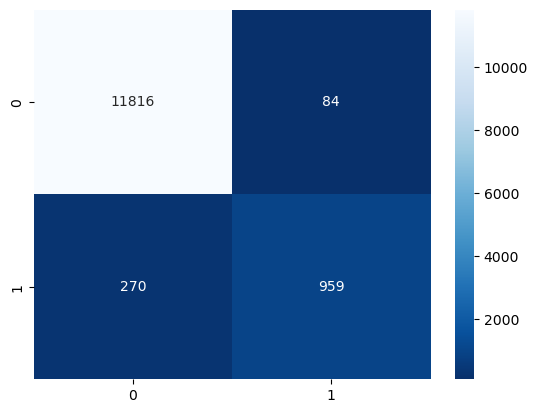

In [89]:
cm = confusion_matrix(y_test, preds_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

Мы видим, что наша модель чаще ошибается в том, что предсказывает, что закрытый стартап является действующим. Эту ошибку можно назвать ошибкой второго рода, и, из-за этого, у нас будет высокий показатель recall, по сравнению с precision. Но так как инвесторам важнее, чтобы модель предсказывала все закрытые стартапы, мы должны ориентироваться на уменьшение FN ошибок.

In [90]:
print(f'Recall = ',recall_score(y_test, preds_test))

Recall =  0.7803091944670464


В данном случае у нас отличный показатель precision.

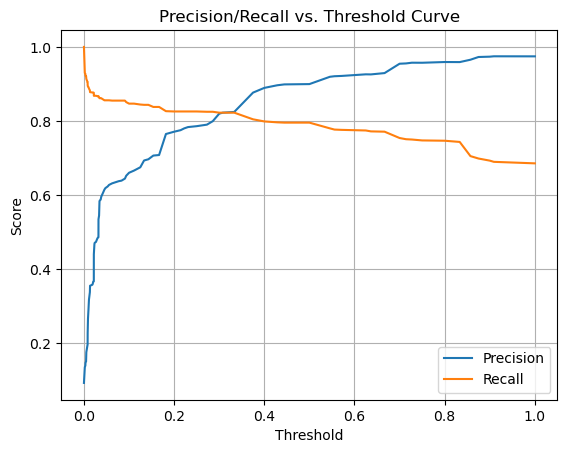

In [91]:
precision, recall, thresholds = precision_recall_curve(y_test, proba_class[:,1])
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision/Recall vs. Threshold Curve')
plt.grid(True)
plt.show()

Для более точного прогнозирования закрытых стартапов можно уменьшить порог до 0.1. 

In [92]:
#подготавливаем тестовые данные к модели
startups_test['geo_region'] = startups_test.apply(country, axis = 1)

In [93]:
startups_test = startups_test.drop(['region', 'category_list',
                                      'first_funding_at','last_funding_at',
                                      'state_code','city','country_code'], axis = 1)

In [94]:
startups_test = startups_test[['funding_total_usd','geo_region','funding_rounds','first_last_funding_diff',
              'lifetime','first_funding_year']]

In [95]:
predicts = randomized_search.best_estimator_.predict(startups_test)

In [96]:
startups_test['status'] = predicts

In [97]:
startups_test.head(5)

,funding_total_usd,geo_region,funding_rounds,first_last_funding_diff,lifetime,first_funding_year,status
name,,,,,,,
Crystalsol,2819200.0,Central America,1,0,3501,2009,0
JBI Fish & Wings,2000000.0,North America,1,0,2717,2010,0
COINPLUS,428257.0,Western Europe,2,126,1295,2014,0
Imagine Communications,34700000.0,North America,4,1935,4748,2005,0
DNA13,4530000.0,unknown,1,0,6209,2007,0


In [98]:
#возвращаем operating и closed в целевом признаке
startups_test['status'] = startups_test.apply(status_cat, axis = 1)

In [99]:
final = startups_test.copy()

In [100]:
final.head(5)

,funding_total_usd,geo_region,funding_rounds,first_last_funding_diff,lifetime,first_funding_year,status
name,,,,,,,
Crystalsol,2819200.0,Central America,1,0,3501,2009,operating
JBI Fish & Wings,2000000.0,North America,1,0,2717,2010,operating
COINPLUS,428257.0,Western Europe,2,126,1295,2014,operating
Imagine Communications,34700000.0,North America,4,1935,4748,2005,operating
DNA13,4530000.0,unknown,1,0,6209,2007,operating


In [101]:
#готовим итоговый файл с предсказаниями к выгрузке
final = final.drop(['funding_total_usd', 'geo_region', 'funding_rounds',
       'first_last_funding_diff', 'lifetime'], axis = 1)
final['name'] = final.index
final = final[['name','status']]

In [102]:
final.head(5)

,name,status
name,,
Crystalsol,Crystalsol,operating
JBI Fish & Wings,JBI Fish & Wings,operating
COINPLUS,COINPLUS,operating
Imagine Communications,Imagine Communications,operating
DNA13,DNA13,operating


In [103]:
final.to_csv(r'/Users/macbook/Desktop/start up/final.csv', index=False)

## Анализ признаков

In [104]:
clf = tree.DecisionTreeClassifier(random_state=RANDOM_STATE)
clf = clf.fit(X_train, y_train)

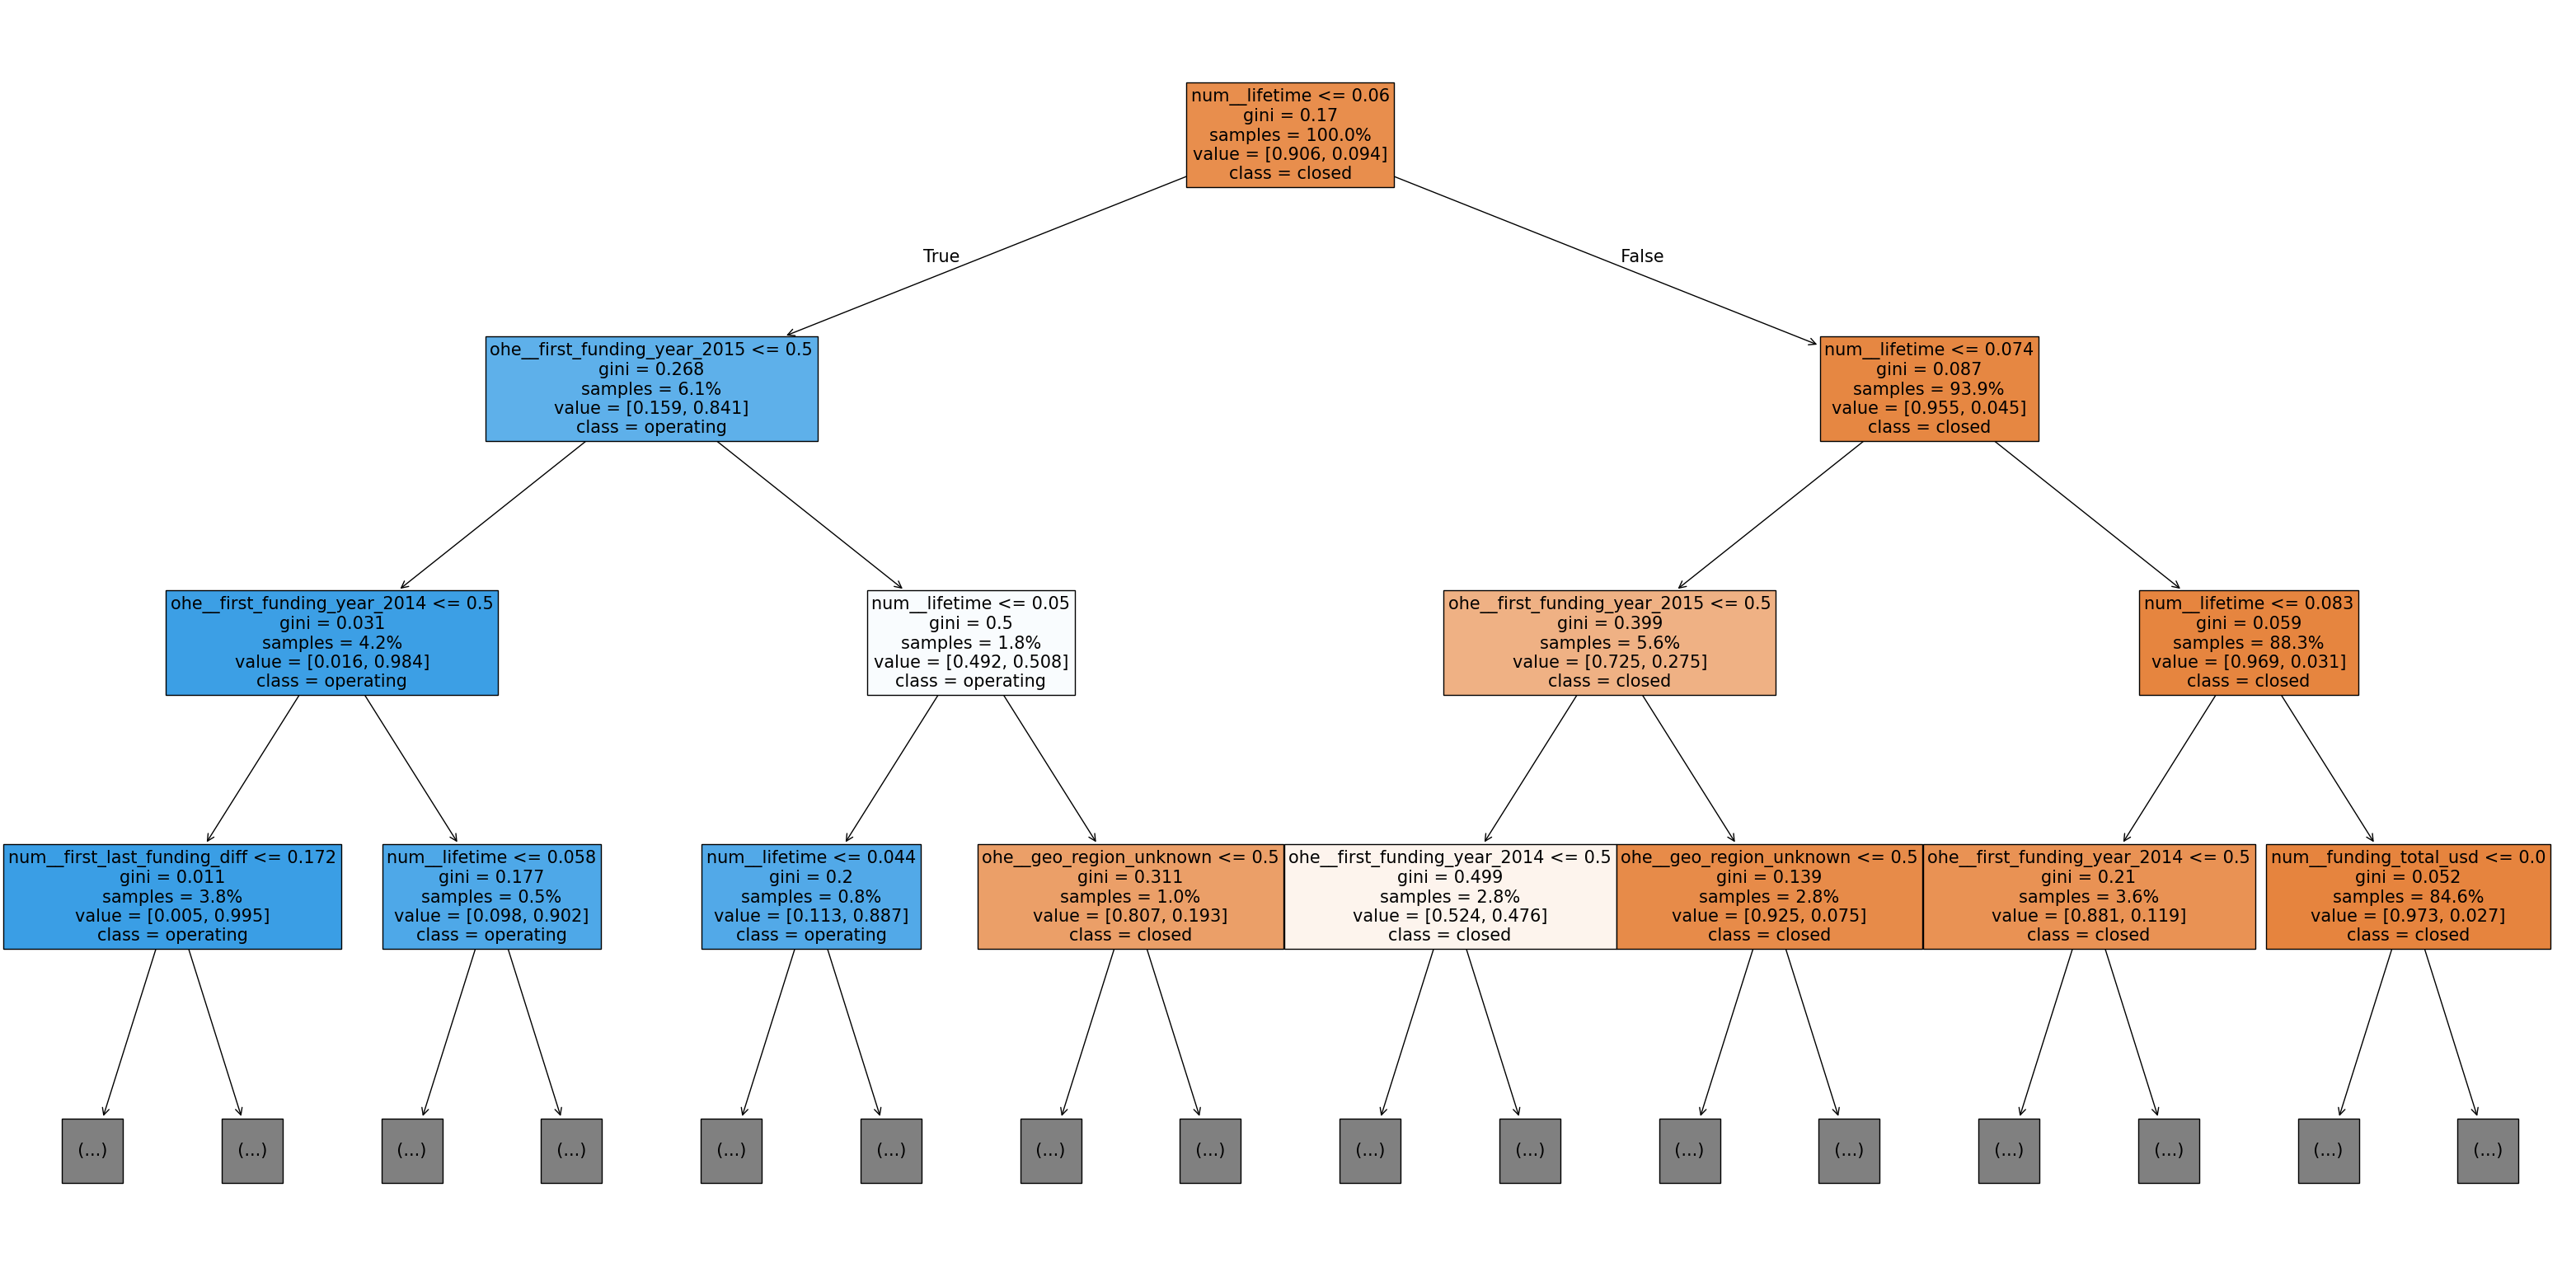

In [105]:
fig = plt.figure(figsize=(40,20))
_ = tree.plot_tree(clf,

               class_names=['closed','operating'],
               filled=True,
               fontsize = 15,
               max_depth = 3,
               feature_names=X_train.columns,
               proportion=True
                  )

Данное дерево показывает нам, что стартап с первым раундом финансирования в 2014 году, нулевой суммой финансирования, неизвестным географическым положением скорее всего закроется. 

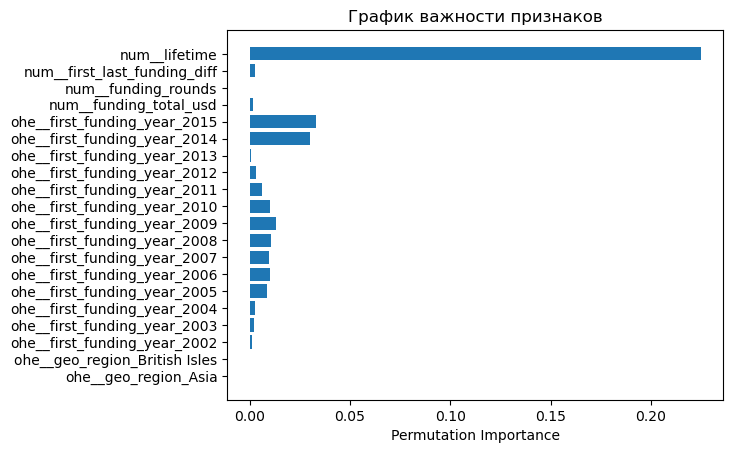

In [106]:
perm_importance = permutation_importance(randomized_search.best_estimator_.named_steps['models'],
                                         X_test, y_test)

feature_names = X_test.columns
features = np.array(feature_names)

sorted_idx = (perm_importance.importances_mean.argsort()) > 30
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title('График важности признаков');


<font color='green'>
<b>Комментарий студента</b>
    
    
Подскажите, что нужно сделать, чтобы в порядке убывания признаки показывались? У меня не получилось разобраться </font>



На графике важности признаков мы видим, что время существования стартапа играет ключевую роль в предсказании его статуса. Также сильное влияние имеет признак первого раунда финансирования - 2014-15, 2005-10 года больше указывают на то, что стартап закроется.

## Вывод

Благодаря нашему исследованию нам удалось создать  модель, которая прогнозирует закрытие стартапа, и, выделить признаки, которые больше всего влияют на наш целевой признак. 

Перед тем, как приступить к исследовательскому анализу, мы провели предобработку данных: заполнили пропуски, искали явные и неявные дубликаты. 

В исследовательском анализе мы изучили признаки закрытого стартапа: они относятся к категории програмного обеспечения, биотехнологии либо их категория отсутствует. Закрытый стартап был основан в Северной Америке, либо страна основания неизвестна. Также, стартапы из Восточной Европы, особенно из Москвы, более склонны к закрытию. Закрытые стартапы из Парижа и Торонто также имеют больше шансов закрыться. Закрытые стартапы реже проходя первый раунд финансирования, не получают больше 200 миллионов долларов финансирования и не существуют больше 8 лет. Такие стартапы также впервые финансировались в 2005-2007 и 2009-2011 годах.

Корреляционный анализ показал, Корреляционный анализ показал, что наш целевой признак больше всего коррелирует со временем существования стартапа, списком категорий, с кодом штата и страной и годом первого финансирования. Самыми незначительными для целевого признака являются признаки, связанные с длительностью работы в компании,  количеством раундов, городом и регионом.

Следующим шагом было создание пайплайна, которое найдет нам лучшую модель для прогноза статуса стартапа. Ею оказалась DesicionTreeClassifier, которая показала 85% F1 метрики. Мы проанализировали прогнозы с помощью графика важности признаков признаков. Он показал нам, что время существование стартапа больше всего влияет на его статус, далее по значимости следуют такие признаки как год первого финансирования и разница между первым и последним финансированием. 